In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df=pd.read_csv('4year.csv')
feature_names=pd.read_csv('feature-mapping.csv')
df.shape

C:\Users\Oshan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,5,6,7,9,10,13,14,15,16,17,21,23,24,25,28,33,34,35,37,47,49,50,56,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(9792, 65)

In [3]:
columnList=feature_names.values.tolist()
column=[]
for item in columnList:
    column.append(item[0])
    
df.columns=column

#df.to_csv('data_with_heads.csv')

In [4]:
#Converting object values to float

feature_columns=[col for col in df.columns if col !="bankruptcy_label"]

for item in feature_columns:
    df[item]=df[item].astype('str')
    df[item]=df[item].apply(lambda x: x.replace('?', '0')).astype('float')

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_validate

Y = df["bankruptcy_label"]
X = df.drop(["bankruptcy_label"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

In [6]:
from sklearn.feature_selection import f_classif


F, pval = f_classif(X.fillna(0),Y)

pval_series = pd.Series(pval, index=X.columns)
pval_threshold = 0.01

best_features = pval_series[pval_series<pval_threshold].sort_values()
print(f"There are {len(best_features)} features with p-value less than {pval_threshold}: \n{best_features}")

There are 14 features with p-value less than 0.01: 
net profit / total assets                                                   3.606270e-13
profit on sales / total assets                                              4.786015e-12
logarithm of total assets                                                   1.171728e-09
(gross profit + interest) / total assets                                    1.204875e-07
EBIT / total assets                                                         1.208821e-07
(gross profit + extraordinary items + financial expenses) / total assets    1.034981e-05
profit on operating activities / total assets                               1.700178e-05
(sales - cost of products sold) / sales                                     2.791602e-05
profit on sales / sales                                                     2.930637e-05
gross profit / total assets                                                 6.450455e-05
gross profit / short-term liabilities                     

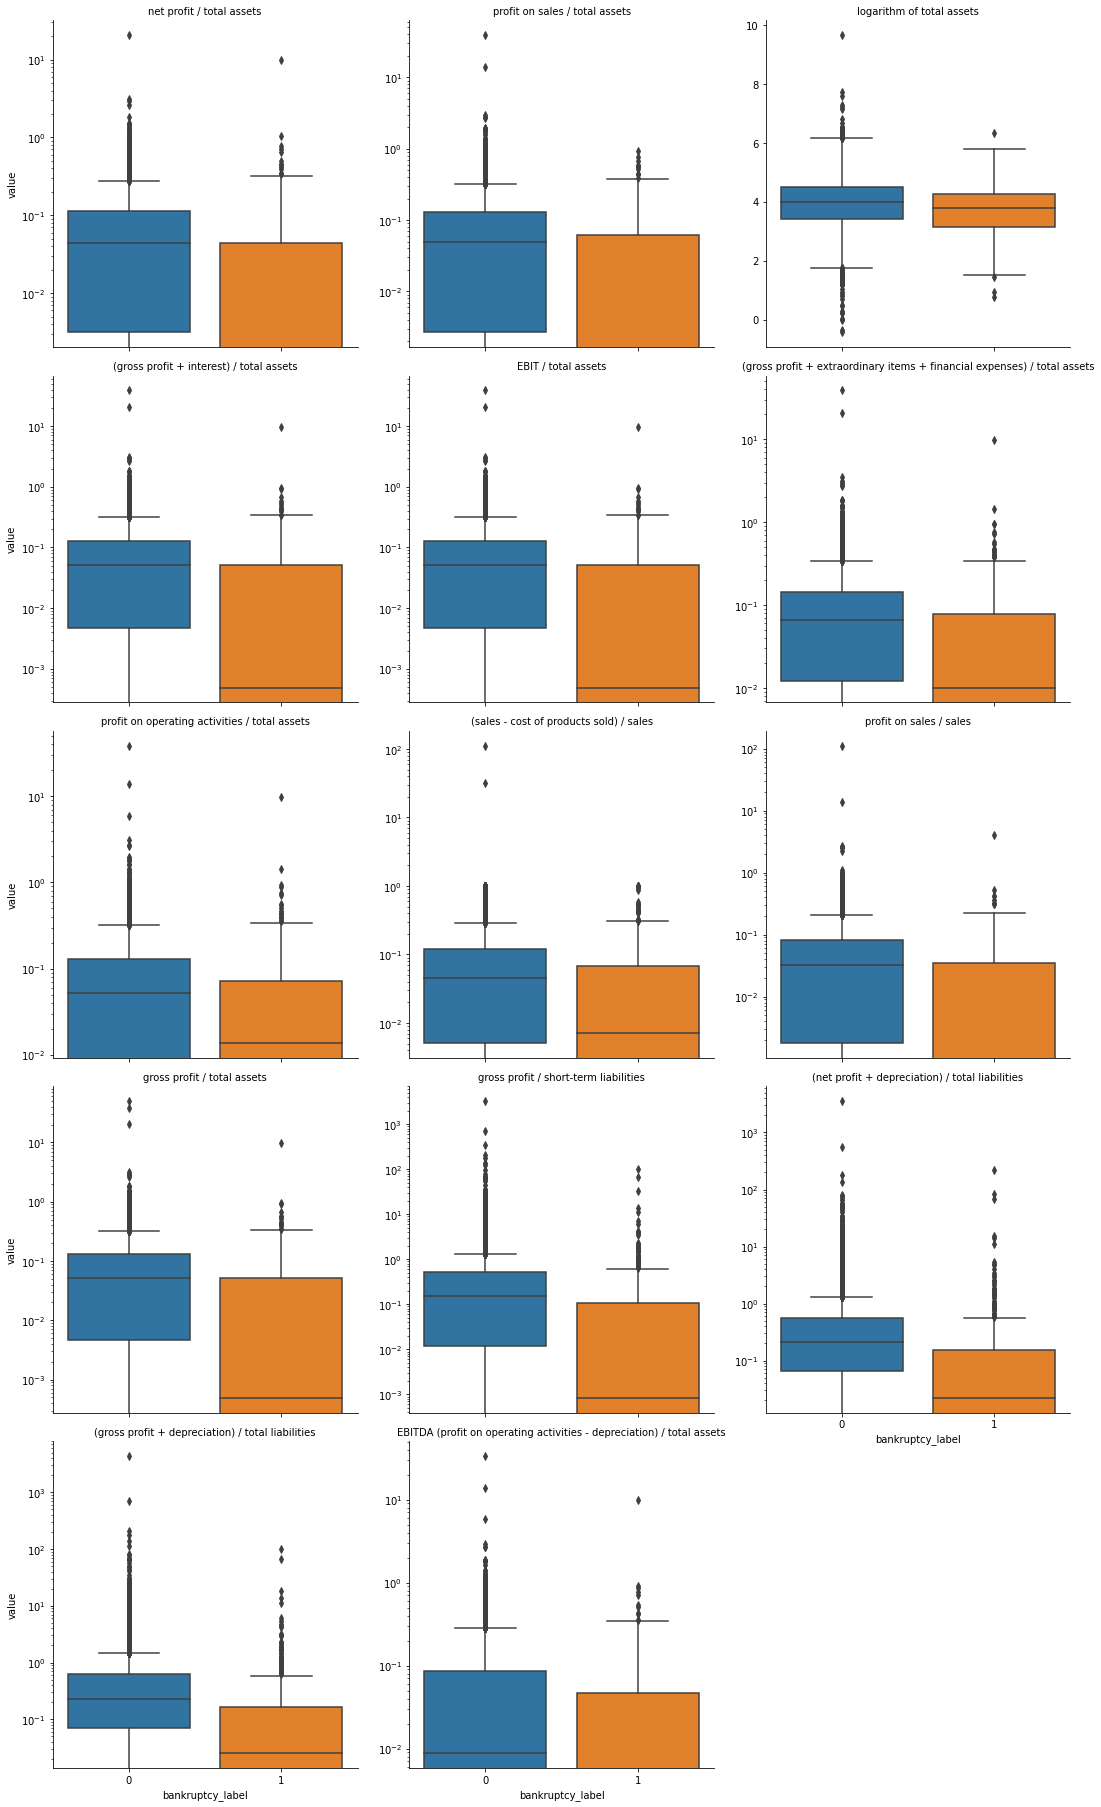

In [7]:

# melt the df to use seaborn function
cols = best_features.index.to_list() + ["bankruptcy_label"]
melted_df = df[cols].reset_index().melt(id_vars=["index", "bankruptcy_label"])

g = sns.catplot(data=melted_df, x="bankruptcy_label", y="value", col="variable", kind="box", col_wrap=3, sharey=False)
g.set_titles(col_template="{col_name}")

# plot in logarithmic scale as there are a few companies with extremely large values 
for ax in g.axes.flatten():
    if ax.get_title() != "logarithm of total assets":
        ax.set_yscale('log')

In [8]:
#making a new dataset with best features

df_with_best_features=df[cols]
df_with_best_features

,net profit / total assets,profit on sales / total assets,logarithm of total assets,(gross profit + interest) / total assets,EBIT / total assets,(gross profit + extraordinary items + financial expenses) / total assets,profit on operating activities / total assets,(sales - cost of products sold) / sales,profit on sales / sales,gross profit / total assets,gross profit / short-term liabilities,(net profit + depreciation) / total liabilities,(gross profit + depreciation) / total liabilities,EBITDA (profit on operating activities - depreciation) / total assets,bankruptcy_label
0,0.159290,0.180820,6.0662,0.189480,0.189480,0.189480,0.180820,0.108990,0.128510,0.189480,0.410250,0.407830,0.473110,0.151530,0
1,-0.127430,-0.115680,3.9891,-0.127430,-0.127430,-0.123210,-0.080134,-0.089372,-0.089372,-0.127430,-0.355870,-0.195060,-0.195060,-0.117360,0
2,0.070488,0.076618,4.6697,0.086895,0.086895,0.086895,0.076618,0.054286,0.067752,0.086895,0.368660,0.433390,0.503000,0.044954,0
3,0.136760,0.144820,4.3239,0.136760,0.136760,0.136760,0.144820,0.102630,0.096688,0.136760,0.377420,0.394960,0.394960,0.121460,0
4,-0.110080,0.050620,3.8426,-0.110080,-0.110080,-0.103100,0.000000,0.439880,0.029176,-0.110080,-0.158200,0.219480,0.219480,-0.263260,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9787,0.004676,0.028662,4.6580,0.013002,0.013002,0.013002,0.028662,-0.029937,0.023320,0.013002,0.026291,0.111030,0.126190,-0.027673,1
9788,-0.027610,0.002675,4.2779,-0.027610,-0.027610,-0.027610,0.002675,0.007198,0.000858,-0.027610,-0.087287,0.078414,0.078414,-0.072569,1
9789,-0.238290,-0.238190,4.9115,-0.240360,-0.240360,-0.240360,-0.238190,-0.245220,-0.393140,-0.240360,-1.629100,-0.284780,-0.288080,-0.297900,1
9790,0.097188,0.090025,4.1226,0.104280,0.104280,0.153640,0.151620,0.288240,0.091726,0.104280,0.178680,0.129070,0.138480,0.151620,1


In [9]:
feature_cols = [col for col in df_with_best_features.columns if col not in ("bankruptcy_label", "index")]

X = df[feature_cols].fillna(0)
y = df["bankruptcy_label"]

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

# first level train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

print(f"Positive class samples in train set: {np.bincount(y_train)[1]}")
print(f"Positive class samples in test set: {np.bincount(y_test)[1]} \n")

# 3-fold cross validation
stratified_cv = StratifiedKFold(n_splits=3)
for (train, validation) , sequence in zip(stratified_cv.split(X_train, y_train), ("first", "second", "third")):
    print(f"Positive class samples in {sequence} validation fold: {np.bincount(y_train.iloc[validation])[1]}")

Positive class samples in train set: 412
Positive class samples in test set: 103 

Positive class samples in first validation fold: 137
Positive class samples in second validation fold: 137
Positive class samples in third validation fold: 138


In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print(f"Before resampling: \n{y_train.value_counts()}")

ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(f"\nAfter oversampling: \n{y_ros.value_counts()}")

rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f"\nAfter undersampling: \n{y_rus.value_counts()}")

Before resampling: 
0    7421
1     412
Name: bankruptcy_label, dtype: int64

After oversampling: 
1    7421
0    7421
Name: bankruptcy_label, dtype: int64

After undersampling: 
1    412
0    412
Name: bankruptcy_label, dtype: int64


In [12]:
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def evaluate_pipeline(pipeline, X_train, y_train, cv):
    """
    Run cross validation for the input pipeline and returns the average precision, recall and F-beta score.
    """
    cv_metrics = cross_validate(pipeline, X_train, y_train, cv=cv, scoring={"precision":"precision", "recall":"recall", "fbeta":make_scorer(fbeta_score, beta=2)})
    cv_metrics_df = pd.DataFrame(cv_metrics)
    average_cv_metrics = cv_metrics_df[["test_precision", "test_recall", "test_fbeta"]].mean()
    return average_cv_metrics

scaler = RobustScaler()
classifier = LogisticRegression(random_state=0, solver='newton-cg', max_iter=200)


# oversampling
oversampling_pipeline = Pipeline([('ros', ros), ('scaler', scaler), ("classifier",classifier)])
oversampling_metrics = evaluate_pipeline(oversampling_pipeline, X_train, y_train, stratified_cv)
print(f"Metrics with random oversampling: \n{oversampling_metrics}\n")

# undersampling
undersampling_pipeline = Pipeline([('rus', rus), ('scaler', scaler), ("classifier",classifier)])
undersampling_metrics = evaluate_pipeline(undersampling_pipeline, X_train, y_train, stratified_cv)
print(f"Metrics with random undersampling: \n{undersampling_metrics}")

Metrics with random oversampling: 
test_precision    0.113960
test_recall       0.601961
test_fbeta        0.324137
dtype: float64

Metrics with random undersampling: 
test_precision    0.107447
test_recall       0.589848
test_fbeta        0.310119
dtype: float64


In [ ]:

from diagnosis import plot_learning_curve

plot_learning_curve(oversampling_pipeline, X_train, y_train, stratified_cv, make_scorer(fbeta_score, beta=2))

In [ ]:
from diagnosis import plot_validation_curve

param_name="classifier__C"
param_range=[0.01, 0.1, 1, 10, 100]

plot_validation_curve(oversampling_pipeline, X_train, y_train, stratified_cv, make_scorer(fbeta_score, beta=2), param_name, param_range, log_scale=True)

ERROR! Session/line number was not unique in database. History logging moved to new session 194


In [13]:
oversampling_pipeline.fit(X_train,y_train)
y_prediction=oversampling_pipeline.predict(X_test)

ERROR! Session/line number was not unique in database. History logging moved to new session 195


In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_prediction,target_names=["non_default", "default"]))

              precision    recall  f1-score   support

 non_default       0.97      0.75      0.85      1856
     default       0.11      0.56      0.19       103

    accuracy                           0.74      1959
   macro avg       0.54      0.66      0.52      1959
weighted avg       0.92      0.74      0.81      1959



In [15]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    

Confusion matrix, without normalization
[[1398  458]
 [  45   58]]


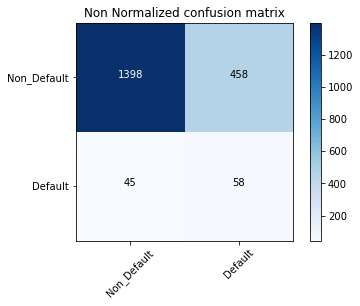

In [17]:
cnf_matrix = confusion_matrix(y_test, y_prediction)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non_Default', 'Default'], normalize=False,
                      title='Non Normalized confusion matrix')

In [18]:
import pickle
with open('probability_of_default_model-14-features.pkl', 'rb') as file:
    PD_Model = pickle.load(file)


FileNotFoundError: [Errno 2] No such file or directory: 'probability_of_default_model-14-features.pkl'

In [ ]:
prediction = PD_Model.predict_proba([[-0.238290,-0.238190,8.9115,-0.240360,-0.240360,-0.240360,-0.238190,-0.245220,-0.393140,-0.240360,-1.629100,-0.284780,-0.288080,-0.297900]])
prediction